In [18]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
sys.path.append('..')
from src.data_processor import DataProcessor
import matplotlib.pyplot as plt
import seaborn as sns

engine = DataProcessor(raw_data='../data/raw', processed_data='../data/processed/')
engine.load_data()


df_trans = engine.df_trans
df_prod = engine.df_prod
df_cust = engine.df_cust


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loaded successfully.


In [19]:
df_trans['shipped_dt'] = pd.to_datetime(df_trans['shipped_dt'], errors='coerce')
df_prod['arrival_date'] = pd.to_datetime(df_prod['arrival_date'], errors='coerce')
df_cust['created_at'] = pd.to_datetime(df_cust['created_at'], errors='coerce')

df_trans['year'] = df_trans['shipped_dt'].dt.year
df_trans['month'] = df_trans['shipped_dt'].dt.month
df_trans['day'] = df_trans['shipped_dt'].dt.day 
df_trans['quarter'] = df_trans['shipped_dt'].dt.quarter
df_trans['dayofweek'] = df_trans['shipped_dt'].dt.day_name()

df_temp = df_trans.merge(df_prod[['item_number', 'arrival_date']], on='item_number', how='left')
df_trans['days_on_market'] = (df_temp['shipped_dt'] - df_temp['arrival_date']).dt.days

df_trans['netrevenue'] = df_trans['netrevenue'].fillna(0)
prod_cols_to_fix = ['category_name', 'color_name', 'motif', 'color_family']
for col in prod_cols_to_fix:
    df_prod[col] = df_prod[col].fillna('Uncategorized')
    
df_cust['region'] = df_cust['region'].fillna('Unknown')
df_cust['business_type'] = df_cust['business_type'].fillna('Other/Designer')


In [20]:
# Identify low-cardinality strings
for col in ['type', 'origin']:
    df_trans[col] = df_trans[col].astype('category')

for col in ['category_name', 'color_family', 'motif']:
    df_prod[col] = df_prod[col].astype('category')

for col in ['business_type', 'region']:
    df_cust[col] = df_cust[col].astype('category')

print(f"Memory saved: {engine.df_trans.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory saved: 350.14 MB


In [21]:
# Left Join Transactions -> Customer (Trade Account)
df_master = df_trans.merge(df_cust, on='trade_account_id', how='left')

# Left Join Result -> Product Master
df_master = df_master.merge(df_prod, on='item_number', how='left')

# Validation: Did we lose rows? (Should still be ~2M)
print(f"Final Master Shape: {df_master.shape}")

Final Master Shape: (1983549, 27)


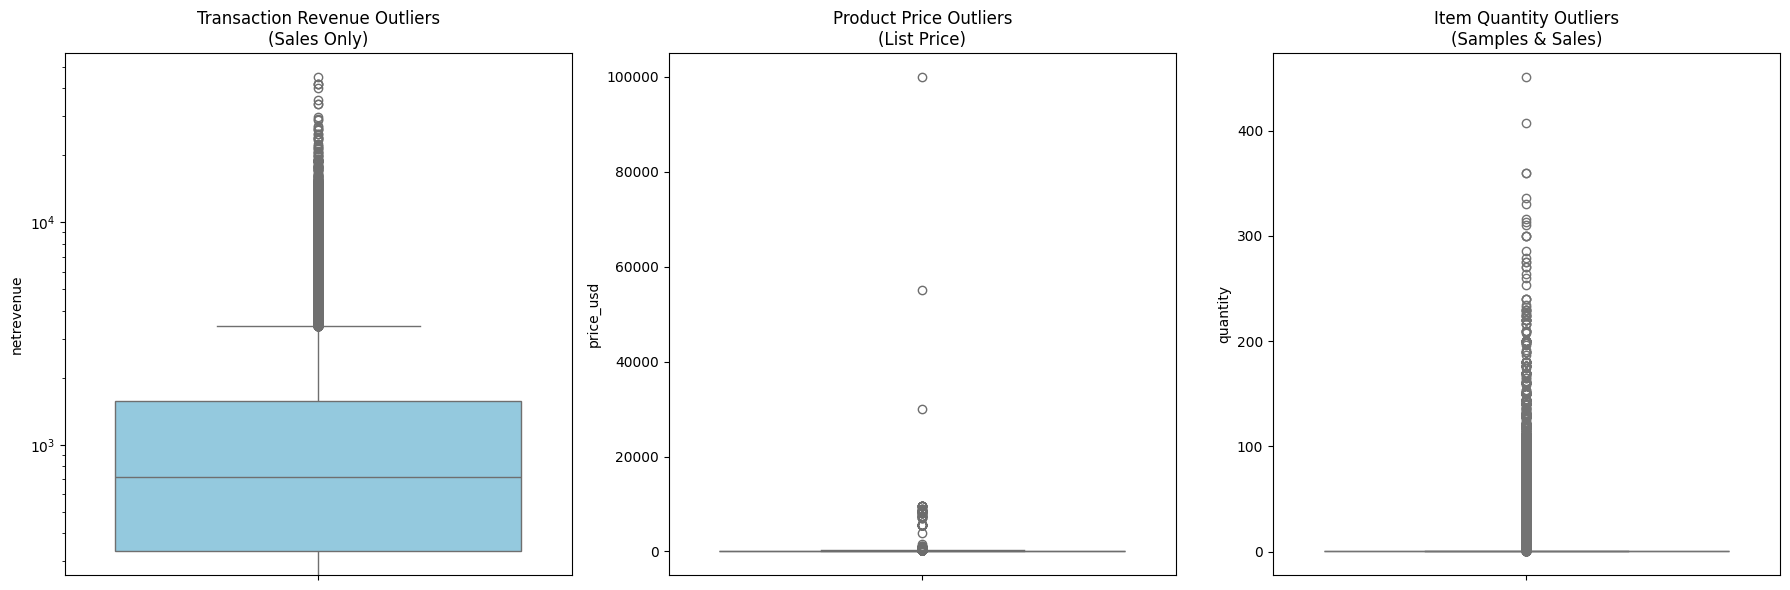

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Transactions: Net Revenue Outliers
sns.boxplot(data=df_trans[df_trans['type'] == 'PRODUCT'], y='netrevenue', ax=axes[0], color='skyblue')
axes[0].set_title('Transaction Revenue Outliers\n(Sales Only)')
axes[0].set_yscale('log')

#Product Master: Price Outliers
sns.boxplot(data=df_prod, y='price_usd', ax=axes[1], color='salmon')
axes[1].set_title('Product Price Outliers\n(List Price)')

#Transactions: Quantity Outliers
sns.boxplot(data=df_trans, y='quantity', ax=axes[2], color='lightgreen')
axes[2].set_title('Item Quantity Outliers\n(Samples & Sales)')

plt.tight_layout()
plt.show()